In [ ]:
from pprint import pprint
from matplotlib import pyplot as plt

import torch
from torch import nn

from main import parse_option
from learner import Learner

In [ ]:
@torch.no_grad()
def visualize_prompt(prompt_learner: nn.Module):
    """Visualizes the prompt."""
    fake_img = torch.ones(1, 3, 224, 224)
    prompted_img = prompt_learner(fake_img).cpu()
    prompted_img = torch.clamp(prompted_img, 0, 1)
    print("Visualizing prompt...")
    plt.imshow(prompted_img[0].permute(1, 2, 0).numpy())

In [ ]:
class CheckersPrompt(nn.Module):
    def __init__(self, image_size: int, square_size: int):
        super().__init__()

        assert isinstance(image_size, int), "image_size must be an integer"
        assert isinstance(square_size, int), "square_size must be an integer"
        assert not image_size % square_size, "image_size must be divisible by square_size"
        
        self.tile = nn.Parameter(torch.randn(1, 3, square_size, square_size))
        self.tile_size = square_size
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, row_id in enumerate(range(0, x.size(2), self.tile_size), 1):
            for j, col_id in enumerate(range(0, x.size(3), self.tile_size), 1):
                if (i % 2 and j % 2) or not (i % 2 or j % 2):
                        x[:, :, row_id : row_id + self.tile_size, col_id : col_id + self.tile_size] += self.tile
        return x

Visualizing prompt...


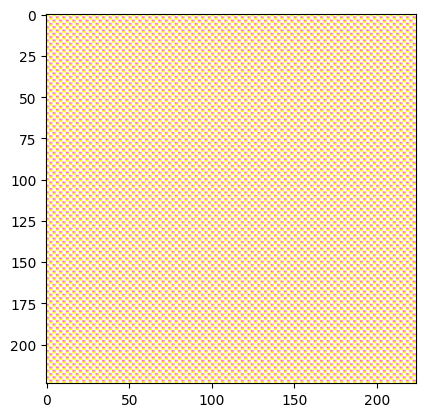

In [ ]:
prompt = CheckersPrompt(224, 2)
visualize_prompt(prompt)

In [ ]:
dummy_in = torch.ones(1, 3, 224, 224)
%timeit x = prompt(dummy_in)

206 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
